# LiVU cohort with pulled demographics

In [8]:
import pandas as pd
pd.options.mode.chained_assignment = None
import os
import glob
from os import path
import numpy as np
from datetime import datetime, timedelta
import matplotlib

### LIVU All
Run nodule detection on all scans

In [60]:
a = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans.csv"
a = pd.read_csv(a)
a

,id
0,8964715287time20171208
1,29045108928time20160406
2,7636455313time20170904
3,4521805785time20171117
4,34156084363time20180709
...,...
4105,35802034477time20181212
4106,34317064156time20170126
4107,16511194870time20180419
4108,3775151383time20181102


In [14]:
root_dir = "/home/local/VANDERBILT/litz/data/livu/DeepLungScreening/nifti"
rows = []
for fname in os.listdir(root_dir):
    rows.append({'id':fname.split('.nii.gz')[0]})
allscans = pd.DataFrame(rows)

# split into 3 jobs for faster processing
for i, job in enumerate([allscans.iloc[:1370], allscans.iloc[1370:1370*2], allscans.iloc[1370*2:]]):
    allscans_path = f"/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans_job{i}.csv"
    job.to_csv(allscans_path, index=False)

In [19]:
path1 = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans_job0.csv"
path2 = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans_job1.csv"
path3 = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans_job2.csv"
job1 = pd.read_csv(path1)
job2 = pd.read_csv(path2)
job3 = pd.read_csv(path3)
job3.merge(job1, on='id')

,id


In [62]:
root_dir = "/home/local/VANDERBILT/litz/data/livu/DeepLungScreening/prep"
all_prepscans_path = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_allscans_prep.csv"
rows = []
for fpath in glob.glob(os.path.join(root_dir, "*_clean.npy")):
    rows.append({'id':os.path.basename(fpath).split('_clean.npy')[0]})
all_prepscans = pd.DataFrame(rows)
all_prepscans.to_csv(all_prepscans_path, index=False)

### LIVU cohort

In [9]:
SPN = False
if SPN:
    scan_path = "/home/local/VANDERBILT/litz/data/mcl/labels/lasko_scanlabels_20221101.csv"
    out_path = "/home/local/VANDERBILT/litz/data/livu/livu_spn_cohort_v1.csv"
else:
    scan_path = "/home/local/VANDERBILT/litz/data/mcl/labels/livu_nospn_scanlabels_prep_v2.csv"
    out_path = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_nospn_prep_cohort_v2.csv"

scans = pd.read_csv(scan_path)
scans = scans[scans['scan_label'].isin([1,2,3])] # usable scans only (1. pre-diagnosis, 2. pre-malig, and 3. malig)
scans['scan_date'] = pd.to_datetime(scans['scan_date'], format='%Y-%m-%d')
scans['label_date'] = pd.to_datetime(scans['label_date'], format='%Y-%m-%d')
print(f"num scans: {len(scans)}")
print(f"num subjects: {len(scans['mcl_id'].unique())}")

demo_path = "/home/local/VANDERBILT/litz/data/livu/rd/livu_demo_raw.csv"
columns = ['mrn', 'mcl_id', 'birthdate', 'sex', 'race', 'ethnicity', 'person_id', 'bmi_date', 'bmi_units', 'bmi']
demo = pd.read_csv(demo_path, usecols = range(10), low_memory=True)
demo.columns = columns
demo = demo[~demo['person_id'].isnull()]
demo

num scans: 252
num subjects: 161


/tmp/ipykernel_340859/3286386714.py:18: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  demo = pd.read_csv(demo_path, usecols = range(10), low_memory=True)


,mrn,mcl_id,birthdate,sex,race,ethnicity,person_id,bmi_date,bmi_units,bmi
0,37387677,23577855652,1947-11-09 00:00,M,W,NH,11951192,2016-02-23,kg/m2,26.95
1,37387677,23577855652,1947-11-09 00:00,M,W,NH,11951192,2016-08-09,kg/m2,25.31
2,37387677,23577855652,1947-11-09 00:00,M,W,NH,11951192,2014-10-28,kg/m2,22.06
3,37387677,23577855652,1947-11-09 00:00,M,W,NH,11951192,2014-12-09,kg/m2,23.88
4,37387677,23577855652,1947-11-09 00:00,M,W,NH,11951192,2014-07-01,kg/m2,23.84
...,...,...,...,...,...,...,...,...,...,...
593422,11213436,31610351302,1946-09-18 00:00,F,W,NH,6827439,2021-09-20,kg/m2,20.01
593423,11213436,31610351302,1946-09-18 00:00,F,W,NH,6827439,2021-09-10,kg/m2,20.07
593424,11213436,31610351302,1946-09-18 00:00,F,W,NH,6827439,2021-02-25,kg/m2,20.32
593425,11213436,31610351302,1946-09-18 00:00,F,W,NH,6827439,2019-02-01,kg/m2,20.52


In [10]:
# data that has been prepped
scans

,mcl_id,scan_date,filename,scan_order,LC_CODE,label_date,scan_label,lung_cancer
5,10760112495,2015-04-27,10760112495time20150427,0,197.0,2017-05-09,2,1
65,14137127166,2016-05-13,14137127166time20160513,0,C34.02,2017-09-08,2,1
69,14463937827,2016-08-23,14463937827time20160823,0,C34.01,2016-08-23,3,1
84,14613309689,2016-05-31,14613309689time20160531,0,C34.12,2016-06-08,3,1
91,14970026206,2013-10-29,14970026206time20131029,0,162.3,2014-12-02,2,1
...,...,...,...,...,...,...,...,...
1222,9677707064,2018-08-19,9677707064time20180819,0,NaN,2019-05-30,3,0
1223,9677707064,2018-11-16,9677707064time20181116,1,NaN,2019-05-30,3,0
1225,9711655189,2018-05-26,9711655189time20180526,0,NaN,2018-07-25,3,0
1228,9895940092,2017-01-03,9895940092time20170103,0,NaN,2018-01-29,2,0


In [11]:
# merge cohort with demo data and preprocess
scans_mcls = scans.groupby('mcl_id', as_index=False).min()
merged = scans_mcls.merge(demo, on='mcl_id', how='left')
merged = merged[~merged['person_id'].isnull()]
# preprocess
def try_strptime(x):
    try: 
        return datetime.strptime(x, '%Y-%m-%d')
    except:
        return np.nan
merged['birthdate'] =pd.to_datetime(merged['birthdate'], format='%Y-%m-%d')
merged['bmi_date'] = merged['bmi_date'].apply(lambda x: try_strptime(x))
merged = merged[~merged['bmi_date'].isnull()]


/tmp/ipykernel_340859/3826545456.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  scans_mcls = scans.groupby('mcl_id', as_index=False).min()


In [12]:
merged['label_date']

0       2019-03-01
1       2019-03-01
2       2019-03-01
3       2019-03-01
4       2019-03-01
           ...    
41478   2014-12-19
41479   2014-12-19
41480   2014-12-19
41481   2014-12-19
41482   2014-12-19
Name: label_date, Length: 41404, dtype: datetime64[ns]

In [13]:
# get bmi that occured closest before spn date + 4 days
def bmi_delta(x):
    # compute days from spn date or lc date to bmi date
    return x['bmi_date'] - x['label_date']
merged['bmi_delta'] = merged.apply(lambda x: bmi_delta(x), axis=1)
min_bmi = merged[merged['bmi_delta'] <= timedelta(days=4)]
idxmin_bmi = min_bmi.groupby('mcl_id')['bmi_delta'].idxmax()
min_bmi = min_bmi.loc[idxmin_bmi]
min_bmi['bmi'] = pd.to_numeric(min_bmi['bmi'], errors='coerce')
min_bmi = min_bmi[min_bmi['bmi']< 100] # remove clear outliers
min_bmi

,mcl_id,scan_date,filename,scan_order,label_date,scan_label,lung_cancer,mrn,birthdate,sex,race,ethnicity,person_id,bmi_date,bmi_units,bmi,bmi_delta
126,66698488,2016-10-18,66698488time20161018,0,2019-03-01,2,1,18308908.0,1960-04-05,F,W,NH,9526897,2018-10-30,kg/m2,28.09,-122 days
284,390776127,2018-05-16,390776127time20180516,0,2018-12-17,3,0,46340392.0,1982-11-11,M,W,NH,38984309,2018-12-21,kg/m2,14.92,4 days
468,476264702,2015-03-31,476264702time20150331,0,2015-03-31,3,0,5930854.0,1955-06-07,M,W,NH,11042335,2015-03-25,kg/m2,29.54,-6 days
1043,553520524,2016-12-16,553520524time20161216,0,2017-02-15,3,1,11295573.0,1961-12-01,M,B,NH,9935263,2017-02-19,kg/m2,26.04,4 days
1542,557278028,2017-09-14,557278028time20170914,0,2018-03-01,3,1,42511717.0,1956-12-02,F,W,NH,7939460,2018-03-01,kg/m2,22.71,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39796,41401448383,2016-03-07,41401448383time20160307,0,2017-01-18,3,1,19899590.0,1944-04-13,F,B,NH,11232232,2017-01-12,kg/m2,25.58,-6 days
40275,42046041233,2016-02-23,42046041233time20160223,0,2016-02-29,3,0,22609218.0,1951-11-27,M,W,NH,5096822,2016-03-03,kg/m2,29.70,3 days
40872,42215796359,2015-03-19,42215796359time20150319,0,2015-03-19,3,0,24951113.0,1963-04-22,F,W,NH,11982896,2015-03-23,kg/m2,29.15,4 days
41159,42477606763,2016-05-11,42477606763time20160511,0,2016-08-30,3,0,3676996.0,1936-04-06,F,W,NH,8567255,2016-08-30,kg/m2,16.12,0 days


/tmp/ipykernel_340859/2144093469.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  age_merged = merged.groupby('mcl_id', as_index=False).max()


158


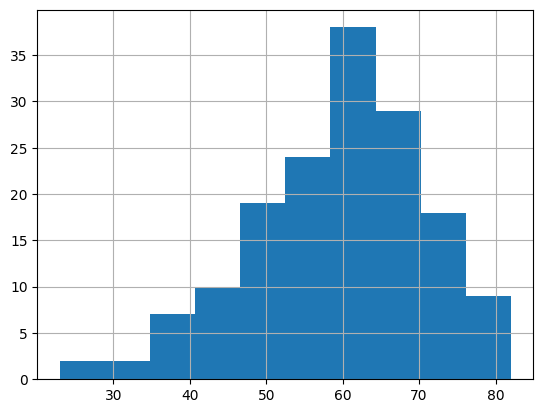

In [14]:
# compute age at spn
def age_at_spn(x):
    event = x['label_date']
    birth = x['birthdate']
    age = event.year - birth.year - ((event.month, event.day) < (birth.month, birth.day))
    return age

age_merged = merged.groupby('mcl_id', as_index=False).max()
age_merged['age'] = age_merged.apply(lambda x: age_at_spn(x), axis=1)
age_merged['age'].hist()
print(len(age_merged))

In [15]:
# left join scans dataframe with bmi and age. Some values will be null
scan_demo = scans.merge(min_bmi[['mcl_id', 'bmi']], on='mcl_id', how='left')
scan_demo = scan_demo.merge(age_merged[['mcl_id', 'age', 'sex', 'race', 'ethnicity']], on='mcl_id', how='left')

# encode sex
def parse_sex(x):
    if pd.isnull(x):
        return x
    else: 
        return np.float(x=='M')
scan_demo['sex'] = scan_demo['sex'].apply(lambda x: parse_sex(x))

# race combines race and ethnicity columns
def parse_race_ethnicity(x):
    race_encoding = {
        'W':1, # caucasian/white
        'B':2, # african american/black
        'A':4, # asian
        'N':5, # Native Hawaiian/ Pacific Islan
        'I':6, # American Indian, Alaska Native
        'D':np.nan # unkown
    }
    if x['ethnicity']=='HL':
        return 3 # hispanic
    elif pd.isnull(x['race']):
        return np.nan
    else:
        return race_encoding[x['race']]

scan_demo['race'] = scan_demo.apply(lambda x: parse_race_ethnicity(x), axis=1)
scan_demo = scan_demo.drop(columns='ethnicity')

/tmp/ipykernel_340859/590198279.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x=='M')


In [16]:
scan_demo['id'] = scan_demo['mcl_id'].astype(str) + 'time' + scan_demo['scan_date'].dt.strftime('%Y%m%d')
scan_demo['id']
scan_demo

,mcl_id,scan_date,filename,scan_order,LC_CODE,label_date,scan_label,lung_cancer,bmi,age,sex,race,id
0,10760112495,2015-04-27,10760112495time20150427,0,197.0,2017-05-09,2,1,20.48,53.0,1.0,1.0,10760112495time20150427
1,14137127166,2016-05-13,14137127166time20160513,0,C34.02,2017-09-08,2,1,18.81,70.0,0.0,1.0,14137127166time20160513
2,14463937827,2016-08-23,14463937827time20160823,0,C34.01,2016-08-23,3,1,35.26,65.0,0.0,2.0,14463937827time20160823
3,14613309689,2016-05-31,14613309689time20160531,0,C34.12,2016-06-08,3,1,34.98,62.0,1.0,1.0,14613309689time20160531
4,14970026206,2013-10-29,14970026206time20131029,0,162.3,2014-12-02,2,1,28.22,77.0,0.0,1.0,14970026206time20131029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,9677707064,2018-08-19,9677707064time20180819,0,NaN,2019-05-30,3,0,41.26,30.0,1.0,1.0,9677707064time20180819
248,9677707064,2018-11-16,9677707064time20181116,1,NaN,2019-05-30,3,0,41.26,30.0,1.0,1.0,9677707064time20181116
249,9711655189,2018-05-26,9711655189time20180526,0,NaN,2018-07-25,3,0,52.04,69.0,1.0,1.0,9711655189time20180526
250,9895940092,2017-01-03,9895940092time20170103,0,NaN,2018-01-29,2,0,34.72,55.0,1.0,1.0,9895940092time20170103


In [36]:
scan_demo.to_csv(out_path, index=False)
a = pd.read_csv(out_path)
a

,mcl_id,scan_date,filename,scan_order,LC_CODE,label_date,scan_label,lung_cancer,bmi,age,sex,race,id
0,10760112495,2015-04-27,10760112495time20150427,0,197.0,2017-05-09,2,1,20.48,53.0,1.0,1.0,10760112495time20150427
1,14137127166,2016-05-13,14137127166time20160513,0,C34.02,2017-09-08,2,1,18.81,70.0,0.0,1.0,14137127166time20160513
2,14463937827,2016-08-23,14463937827time20160823,0,C34.01,2016-08-23,3,1,35.26,65.0,0.0,2.0,14463937827time20160823
3,14613309689,2016-05-31,14613309689time20160531,0,C34.12,2016-06-08,3,1,34.98,62.0,1.0,1.0,14613309689time20160531
4,14970026206,2013-10-29,14970026206time20131029,0,162.3,2014-12-02,2,1,28.22,77.0,0.0,1.0,14970026206time20131029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,9677707064,2018-08-19,9677707064time20180819,0,NaN,2019-05-30,3,0,41.26,30.0,1.0,1.0,9677707064time20180819
248,9677707064,2018-11-16,9677707064time20181116,1,NaN,2019-05-30,3,0,41.26,30.0,1.0,1.0,9677707064time20181116
249,9711655189,2018-05-26,9711655189time20180526,0,NaN,2018-07-25,3,0,52.04,69.0,1.0,1.0,9711655189time20180526
250,9895940092,2017-01-03,9895940092time20170103,0,NaN,2018-01-29,2,0,34.72,55.0,1.0,1.0,9895940092time20170103


### Cross sectional cohort

In [19]:
cs = scan_demo.iloc[scan_demo.groupby('mcl_id')['scan_date'].idxmax()]
cs_path = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_prep_cs.csv"
cs = cs.rename(columns={'mcl_id':'pid', 'scan_order':'session'})
cs.to_csv(cs_path, index=False)

In [18]:
cs

,pid,scan_date,filename,session,LC_CODE,label_date,scan_label,lung_cancer,bmi,age,sex,race,id
68,66698488,2017-01-25,66698488time20170125,1,C78.01,2019-03-01,2,1,28.09,58.0,0.0,1.0,66698488time20170125
208,390776127,2018-05-16,390776127time20180516,0,NaN,2018-12-17,3,0,14.92,36.0,1.0,1.0,390776127time20180516
224,476264702,2015-03-31,476264702time20150331,0,NaN,2015-03-31,3,0,29.54,59.0,1.0,1.0,476264702time20150331
60,553520524,2016-12-16,553520524time20161216,0,162.9,2017-02-15,3,1,26.04,55.0,1.0,2.0,553520524time20161216
62,557278028,2018-01-27,557278028time20180127,1,C34.02,2018-03-01,3,1,22.71,61.0,0.0,1.0,557278028time20180127
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,41401448383,2016-09-21,41401448383time20160921,1,162.4,2017-01-18,3,1,25.58,72.0,0.0,2.0,41401448383time20160921
221,42046041233,2016-02-23,42046041233time20160223,0,NaN,2016-02-29,3,0,29.70,64.0,1.0,1.0,42046041233time20160223
222,42215796359,2015-03-19,42215796359time20150319,0,NaN,2015-03-19,3,0,29.15,51.0,0.0,1.0,42215796359time20150319
223,42477606763,2016-05-11,42477606763time20160511,0,NaN,2016-08-30,3,0,16.12,80.0,0.0,1.0,42477606763time20160511


In [63]:
cs['lung_cancer'].value_counts()

0    102
1     59
Name: lung_cancer, dtype: int64

### Lognitudinal cohort

/tmp/ipykernel_4004757/3209463520.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  a = long.groupby('mcl_id').max()


0    41
1    16
Name: lung_cancer, dtype: int64


,mcl_id,scan_date,filename,scan_order,LC_CODE,label_date,scan_label,lung_cancer,bmi,age,sex,race,id,latest_scan_date,Duration
27,66698488,2017-01-25,66698488time20170125,1,C78.01,2019-03-01,2,1,28.09,58.0,0.0,1.0,66698488time20170125,2017-01-25,0
26,66698488,2016-10-18,66698488time20161018,0,C78.01,2019-03-01,2,1,28.09,58.0,0.0,1.0,66698488time20161018,2017-01-25,99
23,557278028,2018-01-27,557278028time20180127,1,C34.02,2018-03-01,3,1,22.71,61.0,0.0,1.0,557278028time20180127,2018-01-27,0
22,557278028,2017-09-14,557278028time20170914,0,C34.02,2018-03-01,3,1,22.71,61.0,0.0,1.0,557278028time20170914,2018-01-27,135
52,1458406465,2015-01-19,1458406465time20150119,2,NaN,2021-01-26,1,0,38.92,71.0,1.0,1.0,1458406465time20150119,2015-01-19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,40609545758,2017-05-13,40609545758time20170513,2,NaN,2018-12-14,2,0,20.52,63.0,0.0,2.0,40609545758time20170513,2018-12-14,580
131,40929339288,2017-01-16,40929339288time20170116,2,NaN,2019-01-14,2,0,26.72,82.0,0.0,2.0,40929339288time20170116,2017-01-16,0
130,40929339288,2016-08-22,40929339288time20160822,1,NaN,2019-01-14,2,0,26.72,82.0,0.0,2.0,40929339288time20160822,2017-01-16,147
21,41401448383,2016-09-21,41401448383time20160921,1,162.4,2017-01-18,3,1,25.58,72.0,0.0,2.0,41401448383time20160921,2016-09-21,0


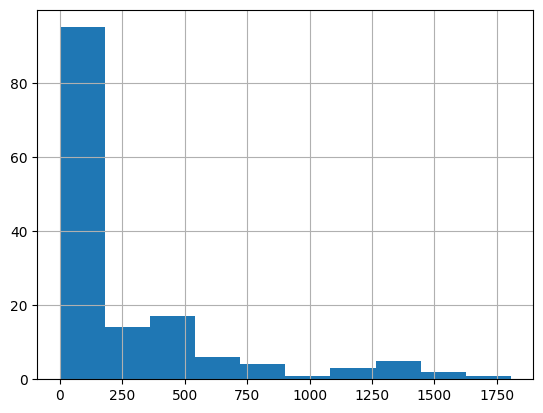

In [64]:
# subjects with at least 2 scans
long = scan_demo[~scan_demo['filename'].isnull()]
long_pids = long.groupby('mcl_id', as_index=False)['id'].count()
long_pids = long_pids[long_pids['id']>1]
long = long.merge(long_pids['mcl_id'], on='mcl_id')

# # num subjects w/ longitudinal img per cohort
a = long.groupby('mcl_id').max()
print(a['lung_cancer'].value_counts())

# # compute relative time distance between each scan
max_date = long.groupby('mcl_id', as_index=False)['scan_date'].max()
max_date = max_date.rename(columns={'scan_date': 'latest_scan_date'})
long = long.merge(max_date, on='mcl_id')
long['Duration'] = long['latest_scan_date'] - long['scan_date']
long['Duration'] = long['Duration'].apply(lambda x: x.days)

long['Duration'].hist()
# # get 2 latest scan per subject
two_scan = long.loc[long.groupby('mcl_id')['scan_order'].nlargest(2).index.get_level_values(1)]
two_scan

In [55]:
two_scan_path = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/livu/livu_prep_twoscan_v2.csv"
two_scan = two_scan.rename(columns={'mcl_id':'pid', 'scan_order':'session'})
two_scan.to_csv(two_scan_path, index=False)

In [65]:
two_scan

,mcl_id,scan_date,filename,scan_order,LC_CODE,label_date,scan_label,lung_cancer,bmi,age,sex,race,id,latest_scan_date,Duration
27,66698488,2017-01-25,66698488time20170125,1,C78.01,2019-03-01,2,1,28.09,58.0,0.0,1.0,66698488time20170125,2017-01-25,0
26,66698488,2016-10-18,66698488time20161018,0,C78.01,2019-03-01,2,1,28.09,58.0,0.0,1.0,66698488time20161018,2017-01-25,99
23,557278028,2018-01-27,557278028time20180127,1,C34.02,2018-03-01,3,1,22.71,61.0,0.0,1.0,557278028time20180127,2018-01-27,0
22,557278028,2017-09-14,557278028time20170914,0,C34.02,2018-03-01,3,1,22.71,61.0,0.0,1.0,557278028time20170914,2018-01-27,135
52,1458406465,2015-01-19,1458406465time20150119,2,NaN,2021-01-26,1,0,38.92,71.0,1.0,1.0,1458406465time20150119,2015-01-19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,40609545758,2017-05-13,40609545758time20170513,2,NaN,2018-12-14,2,0,20.52,63.0,0.0,2.0,40609545758time20170513,2018-12-14,580
131,40929339288,2017-01-16,40929339288time20170116,2,NaN,2019-01-14,2,0,26.72,82.0,0.0,2.0,40929339288time20170116,2017-01-16,0
130,40929339288,2016-08-22,40929339288time20160822,1,NaN,2019-01-14,2,0,26.72,82.0,0.0,2.0,40929339288time20160822,2017-01-16,147
21,41401448383,2016-09-21,41401448383time20160921,1,162.4,2017-01-18,3,1,25.58,72.0,0.0,2.0,41401448383time20160921,2016-09-21,0
